# 1. Setup and Imports
* Import all necessary libraries.
* Import utility functions
  * ECGUtils module contains custom functions to exctract heartbeat segments and build the test model. This library was created to ensure there is no duplicate code in the different notebookes developed.
* Mount Google Drive to access data from MIT-BIH database and synthetic data generated from the GAN.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import glob
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from google.colab import drive

In [3]:
# Mount drive to access the database and synthetic data
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Imports local libraries
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Masters_Code/Utils')

from ECGUtils import ECGUtils

# 2. Load Data

## 2.1. Loading Synthetic Data (GAN Generated)
* Load synthetic heartbeat segments generated by the GAN.
* Create dictionaries to hold these synthetic segments and their labels.
* We ensure that the shape of each synthetic segment is consistent (256 data points).

In [5]:
# Define the path to your synthetic data files
synthetic_data_files = {
    'N': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_N.npy',
    'L': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_L.npy',
    'R': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_R.npy',
    'V': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_V.npy',
    'A': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_A.npy'
}

# Initialize dictionaries to hold synthetic data
synthetic_segments = {}
synthetic_labels = {}

# Load each synthetic data file
for class_label, file_name in synthetic_data_files.items():
    data = np.load(file_name)

    # Reshape if necessary
    if data.shape[-1] != 256:
        data = data.reshape(-1, 256)

    # Store the data and corresponding labels
    synthetic_segments[class_label] = data
    synthetic_labels[class_label] = [class_label] * data.shape[0]

print("Synthetic data loaded.")

Synthetic data loaded.


## 2.2. Loading Original Data
* Define the heartbeat classes of interest (N, L, R, V, A)
* Load read ECG data from the MIT-BIH Arrhythmia Database.
* `ECGUtils` is used to exctract all heartbeat segments belonging to these classes.
  * `ECGUtils.extract_heartbeat_segments()` is a helper function that processes the MIT-BIH data and extracts individual heartbeats labeled by class.

In [6]:
# Define the heartbeat classes
heartbeat_classes = ['N', 'L', 'R', 'V', 'A']

# Initialize lists to store segments and labels
segments = []
labels = []

# List of records in the MIT-BIH dataset
record_files = glob.glob('/content/drive/My Drive/Colab Notebooks/Datasets/mitbih_data/*.dat')
record_names = [os.path.basename(f).split('.')[0] for f in record_files]

# Exclude records with paced beats
excluded_records = ['102', '104', '107', '217']
record_names = [rec for rec in record_names if rec not in excluded_records]

# Extract heartbeat segments for the target classes
segments, labels = ECGUtils.extract_heartbeat_segments(record_names, heartbeat_type=heartbeat_classes, max_segments=-1)

print("Data collection completed.")
print("Total number of samples collected:", len(segments))

100%|██████████| 44/44 [00:51<00:00,  1.17s/it]

Data collection completed.
Total number of samples collected: 95801


**Explore class distribution of Original Data**
* Examine how many samples each class has.
  * Understanding the class imbalance is needed when deciding how many synthetic samples to add to each class.

In [7]:
from collections import Counter

class_counts = Counter(labels)
print("Class distribution:", class_counts)

# Convert lists to numpy arrays for easier processing
segments = np.array(segments)
labels = np.array(labels)

print("Segments shape:", segments.shape)
print("Labels shape:", labels.shape)

Class distribution: Counter({'N': 71868, 'L': 7946, 'R': 7255, 'V': 6503, 'A': 2229})
Segments shape: (95801, 256)
Labels shape: (95801,)


**Encoding labels for Modeling**
* Encode the string labels into numeric form and then convert them to one-hot vectors. (Since neural networks typically work on numerical encodings)
  * **One-hot vector** is a representation of categorical data as a binary vector. In the one-hot vector, all the elements are 0 except for a single 1 that indicates the category or class.

In [8]:
# Encode labels to integers
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
print("Encoded labels:", np.unique(integer_encoded))

# Convert labels to one-hot encoding
one_hot_labels = to_categorical(integer_encoded)
print("One-hot labels shape:", one_hot_labels.shape)

# Count the number of samples per class in the training set
original_class_counts = Counter(labels)
print("Original training data class distribution:", original_class_counts)

Encoded labels: [0 1 2 3 4]
One-hot labels shape: (95801, 5)
Original training data class distribution: Counter({'N': 71868, 'L': 7946, 'R': 7255, 'V': 6503, 'A': 2229})


# 3. Determine Synthetic Samples to Add
* We calculate how many synthetic samples are needed for each class to help balance the dataset.
* The limit `max_synthetic_per_class` is imposed to define the max number of synthetic samples a class can have added.
* The scaling approach is used to avoid adding too many samples to classes that are only slightly smaller than the largest class.

In [9]:
def calculate_synthetic_samples(original_class_counts, max_synthetic_per_class):
    """
    Calculates the number of synthetic samples to add per class.

    Args:
        original_class_counts (dict): Dictionary with class names as keys and their original counts as values.
        max_synthetic_per_class (int): Maximum number of synthetic samples that can be added to any class.

    Returns:
        dict: Dictionary with class names as keys and the number of synthetic samples to add as values.
    """
    # Find the class with most samples
    max_original_samples = max(original_class_counts.values())

    # Calculate the difference between the max and each class's original count
    class_differences = {cls: max_original_samples - count for cls, count in original_class_counts.items()}

    # Find the maximum difference
    max_difference = max(class_differences.values())

    # Calculate the scaling factor
    scaling_factor = max_synthetic_per_class / max_difference

    # Calculate the number of synthetic samples to add per class
    synthetic_samples_needed = {}
    for cls, diff in class_differences.items():
        samples_needed = int(diff * scaling_factor)
        # Ensure the maximum allowed per class is not exceeded
        samples_needed = min(samples_needed, max_synthetic_per_class)
        synthetic_samples_needed[cls] = samples_needed

    return synthetic_samples_needed


max_synthetic_per_class = 2000 # Change this number depending on the desired number of maximum synthetic samples to add per class
synthetic_samples_needed = calculate_synthetic_samples(original_class_counts, max_synthetic_per_class)
for cls, samples_needed in synthetic_samples_needed.items():
    print(f"Class {cls}: {samples_needed} synthetic samples needed.")

Class N: 0 synthetic samples needed.
Class A: 2000 synthetic samples needed.
Class V: 1877 synthetic samples needed.
Class L: 1835 synthetic samples needed.
Class R: 1855 synthetic samples needed.


**Selecting Synthetic Data for Augmentation**
* Based on the calculation above, we now get the required number of synthetic samples for each underrepresented class.

In [10]:
synthetic_segments_to_add = []
synthetic_labels_to_add = []

for class_label, samples_needed in synthetic_samples_needed.items():
    if samples_needed > 0:
        class_synthetic_data = synthetic_segments[class_label]
        # Shuffle the synthetic data
        indices = np.random.permutation(len(class_synthetic_data))
        class_synthetic_data = class_synthetic_data[indices]

        # Select the needed samples
        selected_data = class_synthetic_data[:samples_needed]
        selected_labels = [class_label] * samples_needed

        # Append to the lists
        synthetic_segments_to_add.append(selected_data)
        synthetic_labels_to_add.extend(selected_labels)

print("Synthetic data prepared for augmentation.")

Synthetic data prepared for augmentation.


# 4. Normalizing and Encoding Data
* `StandardScaler` is used to standardize the original and synthetic datasets. This way, both real and synthetic segments have similar scales.
* Just like the original data, we one-hot encode the synthetic labels.

In [11]:
scaler = StandardScaler()
segments_normalized = scaler.fit_transform(segments)
# Reshape data for the model (samples, timesteps, channels)
segments_normalized = segments_normalized.reshape(-1, 256, 1)
print("Segments normalized shape:", segments_normalized.shape)

# Combine synthetic data to be added
if synthetic_segments_to_add:
    synthetic_segments_to_add = np.vstack(synthetic_segments_to_add)
    synthetic_labels_to_add = np.array(synthetic_labels_to_add)
else:
    synthetic_segments_to_add = np.array([]).reshape(0, 256)
    synthetic_labels_to_add = np.array([])

# Normalize synthetic data
if synthetic_segments_to_add.size > 0:
    synthetic_segments_normalized = scaler.transform(synthetic_segments_to_add)
    synthetic_segments_normalized = synthetic_segments_normalized.reshape(-1, 256, 1)
    print("Synthetic data normalized.")
else:
    synthetic_segments_normalized = np.array([]).reshape(0, 256, 1)
    print("No synthetic data to normalize.")

Segments normalized shape: (95801, 256, 1)
Synthetic data normalized.


In [12]:
# Encode labels
if synthetic_labels_to_add.size > 0:
    synthetic_integer_encoded = label_encoder.transform(synthetic_labels_to_add)
    synthetic_one_hot_labels = to_categorical(synthetic_integer_encoded)
    print("Synthetic labels encoded.")
else:
    synthetic_one_hot_labels = np.array([]).reshape(0, len(label_encoder.classes_))
    print("No synthetic labels to encode.")


Synthetic labels encoded.


# 5. Splitting Data into Training, Validation and Test Sets and Augmentation
* The original dataset is first splited into training, validation and test sets.
  * This approach contains approximately 80% training, 10% validation and 10% test data.
* Then the training set is augmented with synthetic data.

In [13]:
# First split into Temporary (training + validation) and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    segments_normalized, one_hot_labels, test_size=0.1, random_state=42, stratify=one_hot_labels)

# Then split the temporary set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp) # 0.1111 x 0.9 ≈ 0.1

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (76640, 256, 1)
Validation set shape: (9580, 256, 1)
Test set shape: (9581, 256, 1)


In [14]:
# Combine original and synthetic training data
X_train_augmented = np.concatenate((X_train, synthetic_segments_normalized), axis=0)
y_train_augmented = np.concatenate((y_train, synthetic_one_hot_labels), axis=0)

print("Augmented training data shape:", X_train_augmented.shape)
print("Augmented training labels shape:", y_train_augmented.shape)

# Shuffle the augmented training data
from sklearn.utils import shuffle
X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented, random_state=42)
print("Augmented training data shuffled.")

# Convert one-hot labels back to integer labels
y_train_augmented_integer = np.argmax(y_train_augmented, axis=1)
y_train_augmented_labels = label_encoder.inverse_transform(y_train_augmented_integer)

# Count the number of samples per class in the augmented training set
augmented_class_counts = Counter(y_train_augmented_labels)
print("Augmented training data class distribution:", augmented_class_counts)

Augmented training data shape: (84207, 256, 1)
Augmented training labels shape: (84207, 5)
Augmented training data shuffled.
Augmented training data class distribution: Counter({'N': 57494, 'L': 8191, 'R': 7659, 'V': 7080, 'A': 3783})


# 6. Build the Models and Train
* Two identical models are created using `ECGUtils.build_test_model()`:
  1. `model_original`: Trained on the original data only.
  2. `model_augmented`: Trained on the augmented data (original + synthetic)
* Both models are compiled with the same optimizer and loss function.

In [15]:
model_original = ECGUtils.build_test_model()
model_original.summary()

model_augmented = ECGUtils.build_test_model()
model_augmented.summary()

model_original.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,285 (5.02 KB)

 Trainable params: 1,285 (5.02 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,285 (5.02 KB)

 Trainable params: 1,285 (5.02 KB)

 Non-trainable params: 0 (0.00 B)

**Training Both Models**
* Both models are trained. The original model uses `X_train, y_train`, while the augmented model uses `X_train_augmented, y_train_augmented`.
* Early stopping and model checkpoints ensure the best weights and avoid overfitting.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_checkpoint_original = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/simple_model_original.keras',
    save_best_only=True, monitor='val_loss'
    )

model_checkpoint_augmented = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/simple_model_augmented.keras',
    save_best_only=True, monitor='val_loss'
    )

In [17]:
history_original = model_original.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint_original]
)

Epoch 1/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6622 - loss: 1.1114 - val_accuracy: 0.8573 - val_loss: 0.5837
Epoch 2/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8684 - loss: 0.5188 - val_accuracy: 0.8747 - val_loss: 0.4432
Epoch 3/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8855 - loss: 0.4120 - val_accuracy: 0.8799 - val_loss: 0.3931
Epoch 4/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8858 - loss: 0.3820 - val_accuracy: 0.8892 - val_loss: 0.3817
Epoch 5/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8897 - loss: 0.3582 - val_accuracy: 0.8838 - val_loss: 0.3681
Epoch 6/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8901 - loss: 0.3543 - val_accuracy: 0.8812 - val_loss: 0.3604
Epoch 7/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8905 - loss: 0.3480 - val_accuracy: 0.8719 - val_loss: 0.3669
Epoch 8/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8935 - loss: 0.3413 - 

In [18]:
history_augmented = model_augmented.fit(
    X_train_augmented, y_train_augmented,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint_augmented]
)

Epoch 1/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6725 - loss: 1.0688 - val_accuracy: 0.8612 - val_loss: 0.5669
Epoch 2/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8640 - loss: 0.5344 - val_accuracy: 0.8836 - val_loss: 0.4329
Epoch 3/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8708 - loss: 0.4471 - val_accuracy: 0.8806 - val_loss: 0.3927
Epoch 4/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8776 - loss: 0.4230 - val_accuracy: 0.8954 - val_loss: 0.3796
Epoch 5/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8841 - loss: 0.4072 - val_accuracy: 0.8977 - val_loss: 0.3649
Epoch 6/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8863 - loss: 0.3961 - val_accuracy: 0.9030 - val_loss: 0.3591
Epoch 7/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8874 - loss: 0.3945 - val_accuracy: 0.8974 - val_loss: 0.3638
Epoch 8/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8876 - loss: 0.3905 - 

# 7. Visualizing Results
* Training and validation accuracy/loss are ploted for each model, to see their learning curves.

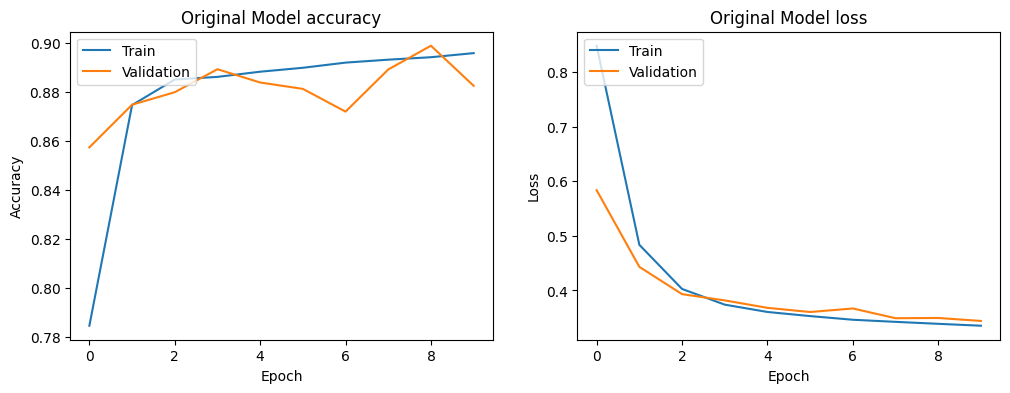

In [19]:
# Plot training & validation accuracy values for Original model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_original.history['accuracy'])
plt.plot(history_original.history['val_accuracy'])
plt.title('Original Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values for Original Model
plt.subplot(1, 2, 2)
plt.plot(history_original.history['loss'])
plt.plot(history_original.history['val_loss'])
plt.title('Original Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

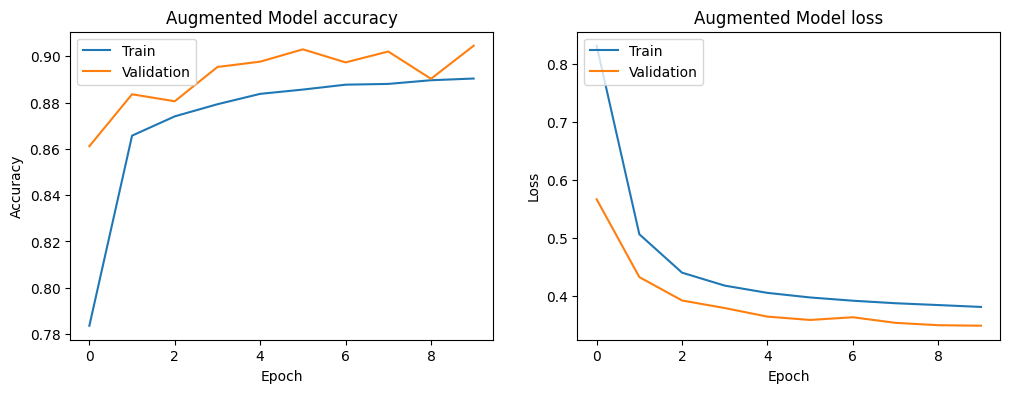

In [20]:
# Plot training & validation accuracy values for Augmented model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['accuracy'])
plt.plot(history_augmented.history['val_accuracy'])
plt.title('Augmented Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values for Augmented model
plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Augmented Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* Loading the best saved weights for both models and evaluating them on the test set. In order to compare the final performance.

In [21]:
# Load the best weights for both models
model_original.load_weights('/content/drive/My Drive/Colab Notebooks/simple_model_original.keras')
model_augmented.load_weights('/content/drive/My Drive/Colab Notebooks/simple_model_augmented.keras')

# Evaluate on test data (Model trained with original and Model trained with augmented data)
test_loss_original, test_accuracy_original = model_original.evaluate(X_test, y_test)
print("Test accuracy Original:", test_accuracy_original)
test_loss_augmented, test_accuracy_augmented = model_augmented.evaluate(X_test, y_test)
print("Test accuracy Augmented:", test_accuracy_augmented)

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8919 - loss: 0.3060
Test accuracy Original: 0.8906168341636658
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9126 - loss: 0.3180
Test accuracy Augmented: 0.9107608795166016


* Generate and compare confusion matrices to understand how each model performs on each class. This helps us see if adding synthetic data improved predictions, especially for classes that were originally underrepresented.

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


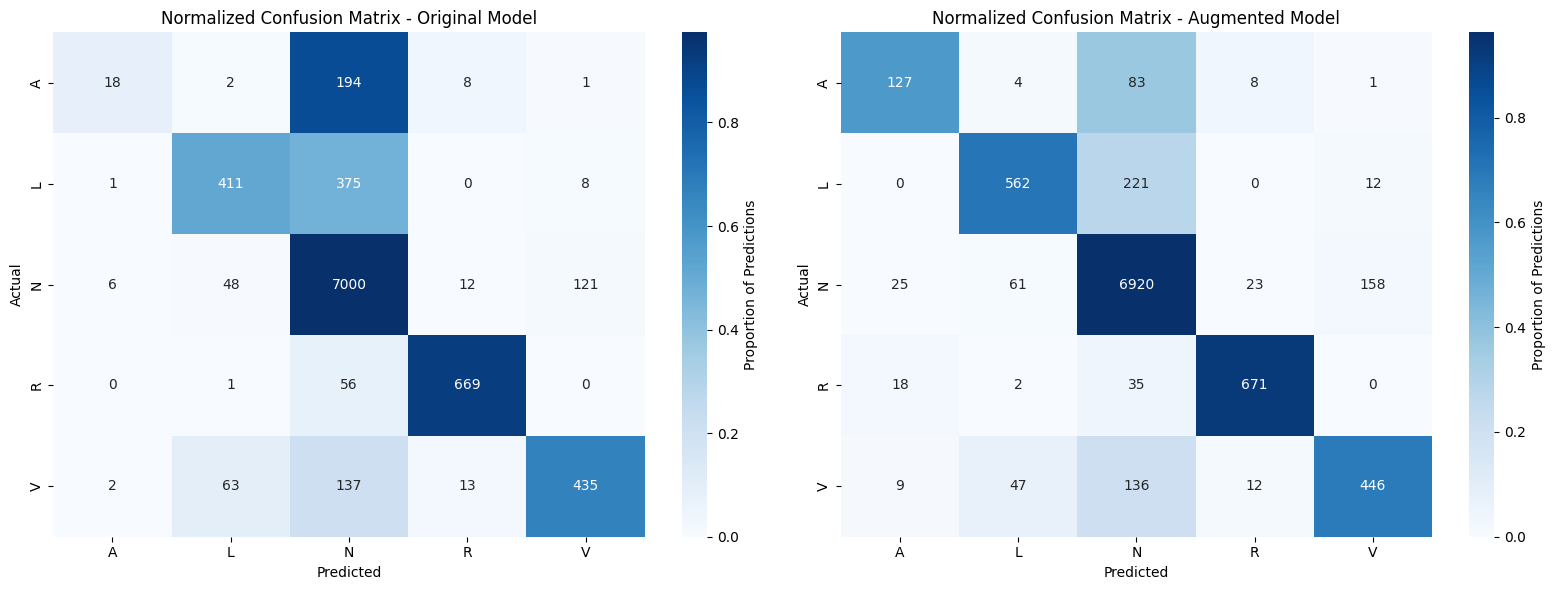

In [22]:
# Generate predictions and plot confusion matrices for both trained models
def plot_comparison_matrices(model_original, model_augmented, X_test, y_test, label_encoder):
    # Model 1: Original
    y_pred_probs_original = model_original.predict(X_test)
    y_pred_original = np.argmax(y_pred_probs_original, axis=1)
    y_true = np.argmax(y_test, axis=1)

    conf_matrix_original = confusion_matrix(y_true, y_pred_original)
    conf_matrix_normalized_original = conf_matrix_original.astype('float') / conf_matrix_original.sum(axis=1)[:, np.newaxis]
    conf_matrix_normalized_original = np.nan_to_num(conf_matrix_normalized_original)  # Handle division by zero

    # Model 2: Augmented
    y_pred_probs_augmented = model_augmented.predict(X_test)
    y_pred_augmented = np.argmax(y_pred_probs_augmented, axis=1)

    conf_matrix_augmented = confusion_matrix(y_true, y_pred_augmented)
    conf_matrix_normalized_augmented = conf_matrix_augmented.astype('float') / conf_matrix_augmented.sum(axis=1)[:, np.newaxis]
    conf_matrix_normalized_augmented = np.nan_to_num(conf_matrix_normalized_augmented)  # Handle division by zero

    # Plot side-by-side confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Original model
    sns.heatmap(conf_matrix_normalized_original, annot=conf_matrix_original, fmt='d',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                cmap='Blues', cbar_kws={'label': 'Proportion of Predictions'}, ax=axes[0])
    axes[0].set_title('Normalized Confusion Matrix - Original Model')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')

    # Augmented model
    sns.heatmap(conf_matrix_normalized_augmented, annot=conf_matrix_augmented, fmt='d',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                cmap='Blues', cbar_kws={'label': 'Proportion of Predictions'}, ax=axes[1])
    axes[1].set_title('Normalized Confusion Matrix - Augmented Model')
    axes[1].set_ylabel('Actual')
    axes[1].set_xlabel('Predicted')

    plt.tight_layout()
    plt.show()

# Plot the matrices for each model
plot_comparison_matrices(model_original, model_augmented, X_test, y_test, label_encoder)